# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run cell2location](#cell2location)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
#from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

#import cell2location
import scvi
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [3]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'

scvi_run_name = 'v3_lr0002_Adam_signatures'
scvi_ref_run_name = f'{results_folder}regression_model/signatures_v0_Adam_lr0002_ref'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [5]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # for spatial mapping remove MT genes
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

Now let's look at QC: total number of counts and total number of genes per spot

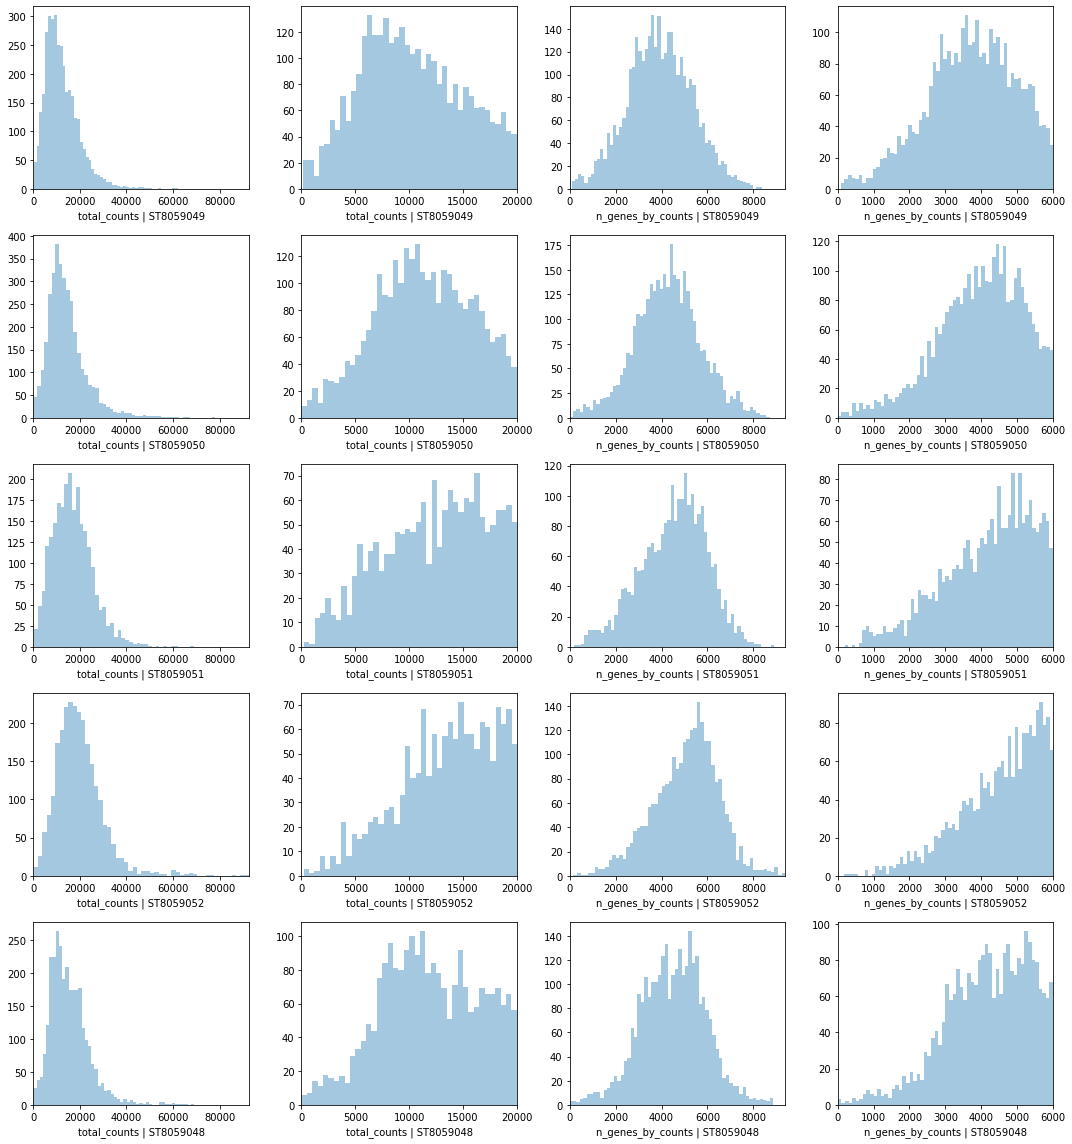

In [6]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


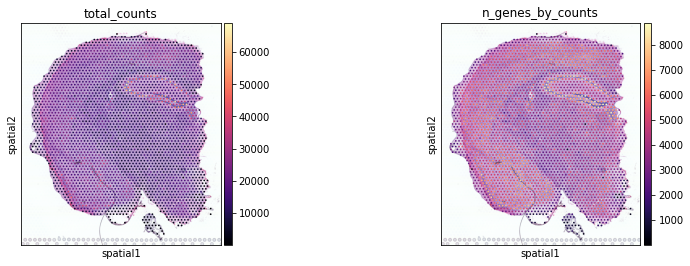

In [7]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

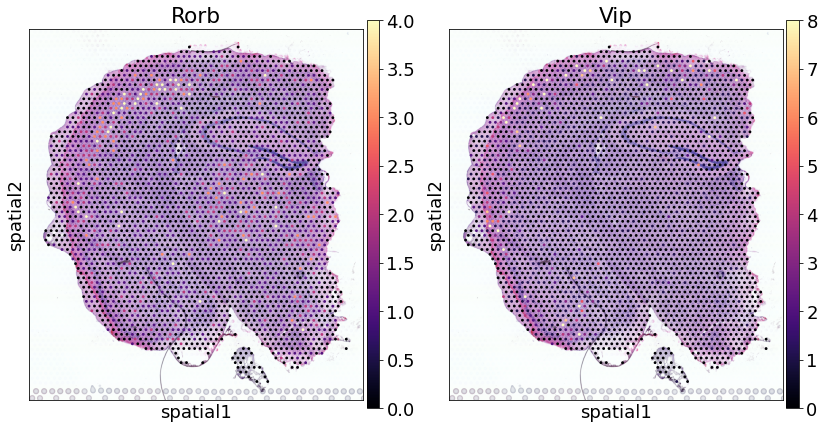

In [8]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(slides['ST8059048'], 
              color=["Rorb", "Vip"], img_key='hires',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


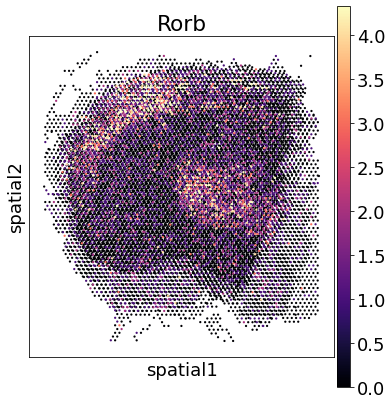

In [9]:
sc.pl.spatial(adata, 
              color=["Rorb"], img_key=None,
              library_id='spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

In [10]:
adata.raw = adata

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [11]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_ref", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

In [12]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO
ENSEMBL,,,,,
ENSMUSG00000051951,0.040710,0.079320,0.057454,0.059812,0.084526
ENSMUSG00000089699,0.004963,0.006407,0.009193,0.007305,0.016441
ENSMUSG00000033845,0.112017,0.054752,0.094273,0.067388,0.081231
ENSMUSG00000033813,0.093426,0.106448,0.136787,0.096871,0.091096
ENSMUSG00000002459,3.554433,4.124567,4.123194,3.952404,1.159038


### Run cell2location <a class="anchor" id="cell2location"></a>

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [16]:
results_folder + 'scvi/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/'

In [17]:
adata_vis = adata.copy()

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14968 cells, 12809 vars, 5        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [18]:
conditions_df = pd.DataFrame({
    'alpha': [1, 10, 20, 50, 100, 200, 500, 1000]
})
conditions = [conditions_df.iloc[i, :] for i in range(conditions_df.shape[0])]
conditions

[alpha    1
 Name: 0, dtype: int64,
 alpha    10
 Name: 1, dtype: int64,
 alpha    20
 Name: 2, dtype: int64,
 alpha    50
 Name: 3, dtype: int64,
 alpha    100
 Name: 4, dtype: int64,
 alpha    200
 Name: 5, dtype: int64,
 alpha    500
 Name: 6, dtype: int64,
 alpha    1000
 Name: 7, dtype: int64]

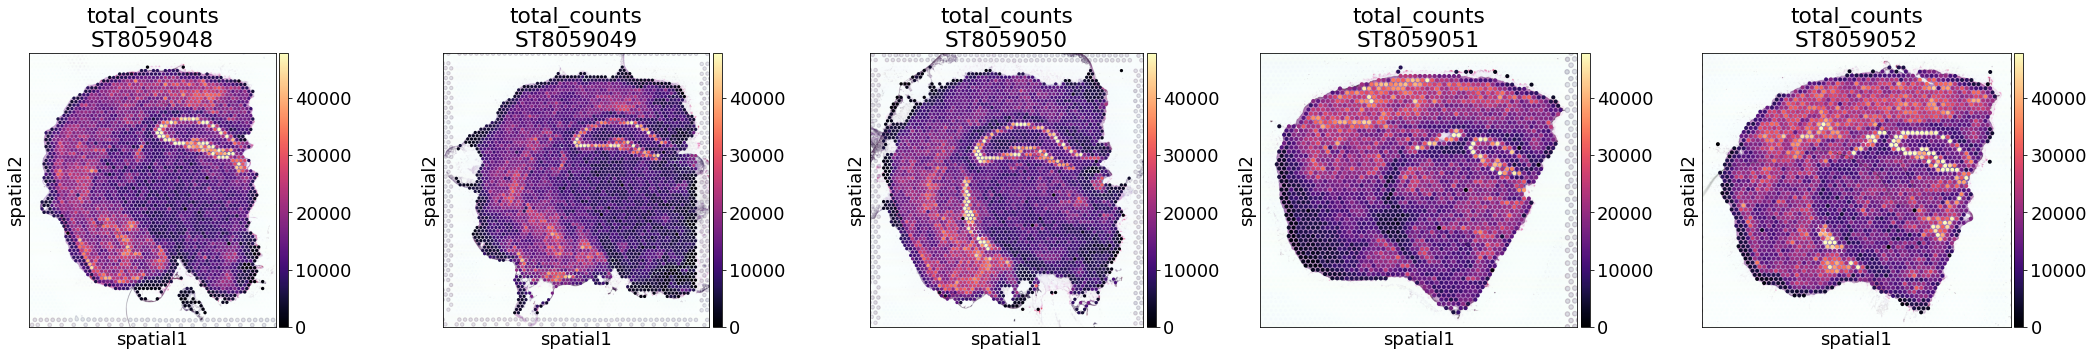

In [19]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

def plot_spatial_per_cell_type(adata, 
                               cell_type='total_counts',
                               samples=adata_vis.obs['sample'].unique(),
                              ncol=5, prefix='', figsize=(30, 5),
                              vmax_quantile=0.992):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{prefix}{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, vmax_quantile)
    adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type='total_counts');

Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_1alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_1alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:42<00:00, 23.51it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_10alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_10alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [01:07<00:00, 14.73it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_20alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_20alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:50<00:00, 19.72it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_50alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_50alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:44<00:00, 22.69it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_100alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_100alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [01:01<00:00, 16.29it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [01:11<00:00, 14.00it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_500alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_500alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [01:08<00:00, 14.54it/s]
Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_1000alphatest
/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_1000alphatest/


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:39<00:00, 25.54it/s]


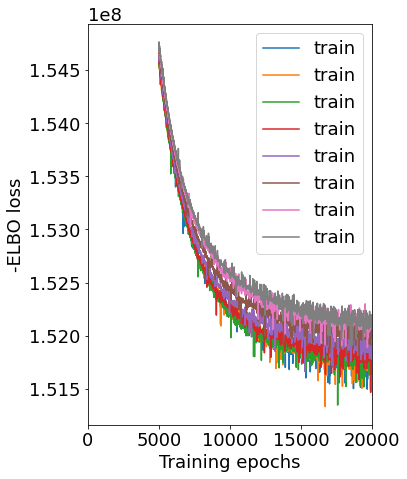

In [16]:
batch_size = None
amortised = False
max_epochs = 20000

#import torch.nn as nn
import pyro

# create and train the model
from scvi.external.cell2location._cell2location_v3_module import LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel

for con in conditions:
    mod = scvi.external.Cell2location(
        adata_vis, cell_state_df=inf_aver, 
        model_class=LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel,
        amortised=amortised, #single_encoder=True,
        #encoder_kwargs={'dropout_rate': 0.1,
        #                'use_batch_norm': False, 'use_layer_norm': True, 
        #                'n_layers': 1, 'activation_fn': nn.LeakyReLU},
        # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
        N_cells_per_location=8,
        detection_alpha=con["alpha"],
    ) 
    
    
    # Save model
    run_name = f'{mod.__class__.__name__}_{mod.summary_stats["n_batch"]}experiments_{mod.n_factors_}clusters_{mod.summary_stats["n_cells"]}locations_{mod.summary_stats["n_vars"]}genes_{batch_size}batch_size_amortised{amortised}_{max_epochs}max_epochs_{con["alpha"]}alphatest'
    print(run_name)
    scvi_run_name_ = f'{results_folder}scvi/{scvi_run_name}_c2l_{run_name}/'
    print(scvi_run_name_)

    mod.train(max_epochs=max_epochs, 
              batch_size=batch_size, 
              train_size=1,
              #lr=0.005,
              #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.003,
              #                                                         'clip_norm': 10})},
              plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
              use_gpu=True)

    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(5000)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size':  mod.adata.n_obs, 'use_gpu': True}
    )


    mod.save(f"{scvi_run_name_}", overwrite=True)
    # can be loaded later like this:
    # mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

    # Save anndata object with results
    adata_file = f"{scvi_run_name_}/sp.h5ad"
    adata_vis.write(adata_file)
    adata_file

In [20]:
from glob import glob
from re import sub

dir_names = sorted(glob(f'{results_folder}scvi/v3_lr0002_Adam_signatures*alphatest'),
                   key=lambda x: int(x.split('_')[-1][:-9]))

test_names = [sub('^.+/', '', i)for i in dir_names]
test_alpha_names = [sub('^.+_', '', i)for i in dir_names]
test_alpha_values = np.array([int(sub('alphatest', '', i)) for i in test_alpha_names])

dfs = []

for dir_name in dir_names:
    adata_vis_res = sc.read(f'{dir_name}/sp.h5ad')
    #cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
    #cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
    #cell_count_columns = cell_count.columns
    #cell_proportions = (cell_count.T / cell_count.sum(1)).T
    #cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
    
    w_sf = adata_vis_res.obsm['means_cell_abundance_w_sf']
    w_sf.columns =  [sub('meanscell_abundance_w_sf_', '', i) for i in w_sf.columns]
    infer_cell_proportions = (w_sf.T / w_sf.sum(1)).T
    w_sf['total_w_sf'] = w_sf.sum(1)
    
    dfs.append(w_sf)
    
test_names, test_alpha_names

(['v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_1alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_10alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_20alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_50alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_100alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest',
  'v3_lr0002_Adam_signatures_c2l_Cell2location_5experimen

In [21]:
# read in positions of segmented nuclei for each sample
adata_vis = adata_vis_res.copy()
adata_vis.obs['image_name_i'] = [i[41:-4] for i in adata_vis.obs['image_name']]

segm_res = {}
for i in adata_vis.obs['image_name_i'].unique():
    
    sample_name = adata_vis.obs.loc[adata_vis.obs['image_name_i'] == i,
                                    'sample'].unique()[0]
    
    res = pd.read_csv(results_folder + 'segmentation/' + i + '.csv')
    res['image_name_i'] = i
    res['sample_name'] = sample_name
    segm_res[i] = res
    
    
    # don't load images now to preserve RAM
    #path_segm = 'segmentation/color/' + i + '_color.jpg'
    #from cv2 import imread
    #full_img_segm = imread(path_segm, -1)
    
    #spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    #spatial_name = spatial_names[[sample_name in i for i in spatial_names]][0]
    #adata_vis.uns['spatial'][spatial_name]['scalefactors']['tissue_lowres_scalef'] = 1
    #adata_vis.uns['spatial'][spatial_name]['images']['lowres'] = full_img_segm

segm_res = pd.concat(list(segm_res.values()), axis=0)

# filter segmented nuclei by size
segm_res = segm_res.loc[segm_res['size'] < 10**3.3,:]

def map_nuclei2spots(nuclei_df, adata, sample_ind, radius=None):
    
    from sklearn.neighbors import KDTree
    
    if radius is None:
        
        spatial_names = np.array(list(adata.uns['spatial'].keys()))
        spatial_name = spatial_names[[sample in i for i in spatial_names]][0]
        radius = adata.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2
        
    # count nuclei within spots
    tree = KDTree(nuclei_df[['x', 'y']].values)

    adata.obs.loc[sample_ind, 'nuclei_count'] = tree.query_radius(adata.obsm['spatial'][sample_ind,:],
                                                                  radius, count_only=True)
    # measure averages size and std
    spotind = tree.query_radius(adata.obsm['spatial'][sample_ind,:], radius, count_only=False)
    adata.obs.loc[sample_ind, 'nuclei_size_sum'] = [nuclei_df['size'].values[spot].sum() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_mean'] = [nuclei_df['size'].values[spot].mean() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_std'] = [nuclei_df['size'].values[spot].std() for spot in spotind]
    
    
for s in adata_vis.obs['sample'].unique():
    
    spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    spatial_name = spatial_names[[s in i for i in spatial_names]][0]
    
    map_nuclei2spots(segm_res.loc[segm_res['sample_name'].isin([str(s)]), :], 
                     adata_vis, adata_vis.obs['sample'].isin([s]), 
                     radius=adata_vis.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2 * 1.1)

# compute total number of nuclei per section
segm_res['sample_name'].value_counts()

ST8059049    51300
ST8059048    48357
ST8059050    47831
ST8059052    46507
ST8059051    43680
Name: sample_name, dtype: int64

In [22]:
for i, df in enumerate(dfs):
    dfs[i]['nuclei_count'] = adata_vis.obs['nuclei_count'][df.index]

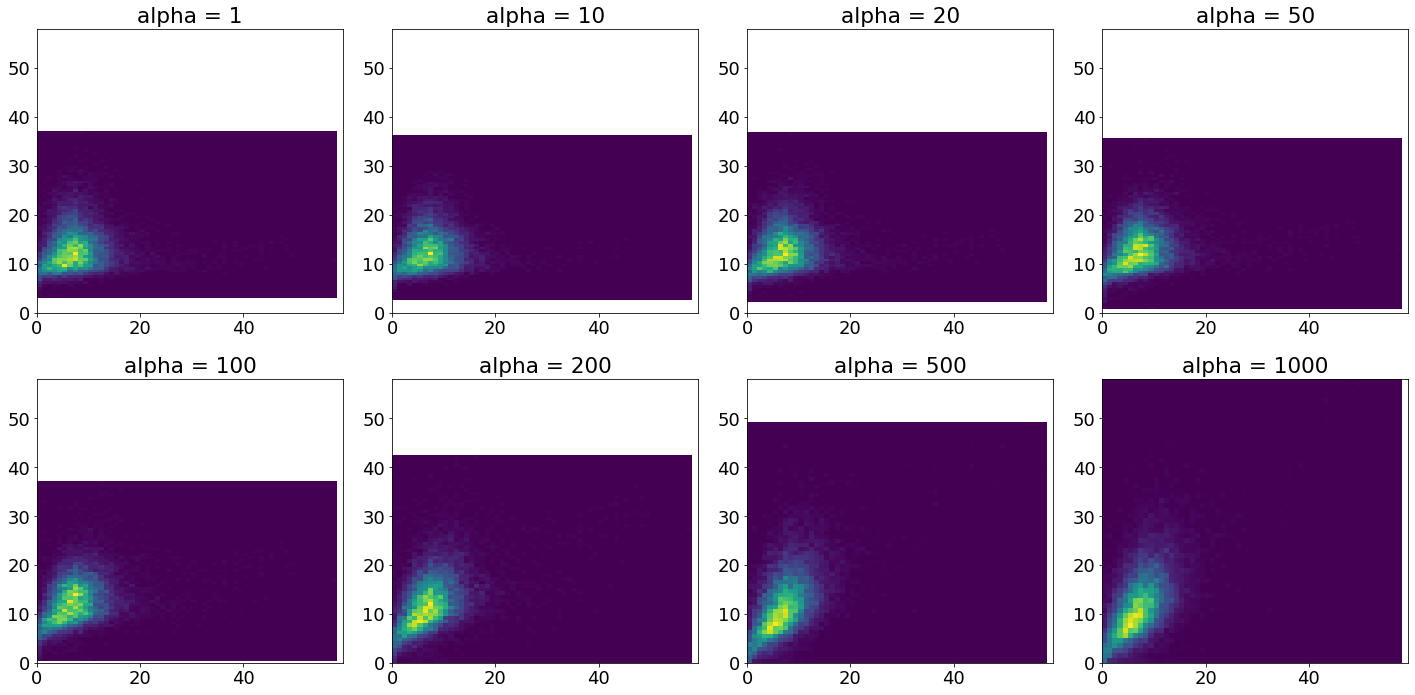

In [28]:
plt.figure(figsize=(20, 10))
total_w_sf_max_val = np.max([df['total_w_sf'].max() for df in dfs])
nuclei_count_max_val = np.max([df['nuclei_count'].max() for df in dfs])

for i, df in enumerate(dfs):
    
    plt.subplot(2, 4, i+1)
    plt.hist2d(df['nuclei_count'], df['total_w_sf'], 
               bins=int(nuclei_count_max_val));
    #plt.ylabel('total cell abundance');
    #plt.xlabel('nuclei count estimated by segmentation');
    plt.xlim(0, total_w_sf_max_val);
    plt.ylim(0, nuclei_count_max_val);
    plt.title(f'alpha = {test_alpha_values[i]}')
    plt.tight_layout();

### Fig S8CD plot correspondence of total cell abundance estimated by cell2location with nuclei count estimated by segmentation

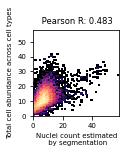

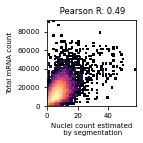

In [60]:
def plot_hist2d(x, y, x_lab, y_lab, title_prefix='',
                x_min=0, y_min=0, axis_equal=True):
    plt.hist2d(x, y, bins=int(np.max(x)), cmap='magma',
               norm=matplotlib.colors.LogNorm(),
              );
    #plt.scatter(x, y);
    plt.xlabel(x_lab);
    plt.ylabel(y_lab);
    plt.xlim(x_min)
    plt.ylim(y_min, np.max([np.max(x), np.max(y)]))
    if axis_equal:
        plt.gca().set_aspect('equal', adjustable='box')
    
    from scipy.stats import spearmanr
    cor = np.corrcoef(x, y)[0, 1]
    cor, pval = spearmanr(x, y)
    plt.title(f'{title_prefix} Pearson R: {np.round(cor, 3)}')

df_alpha200 = dfs[np.where(test_alpha_values == 200)[0][0]]
fig_path = f'{dir_names[np.where(test_alpha_values == 200)[0][0]]}/figures/'

with matplotlib.rc_context({'figure.figsize': (2., 2.), 'font.size': 7}):
    x = df_alpha200['nuclei_count']
    y = df_alpha200['total_w_sf']
    plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
                y_lab=r'Total cell abundance across cell types', 
                title_prefix='')
    plt.tight_layout()
    plt.savefig(f'{fig_path}nuclei_count_VS_total_w_sf.pdf',
                bbox_inches='tight', facecolor='white')
    plt.show()
    
    x = df_alpha200['nuclei_count']
    y = adata_vis.obs['total_counts'][df_alpha200.index]
    plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
                y_lab=r'Total mRNA count', 
                title_prefix='', axis_equal=False)
    plt.tight_layout()
    plt.savefig(f'{fig_path}nuclei_count_VS_total_counts.pdf',
                bbox_inches='tight', facecolor='white')
    plt.show()

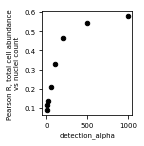

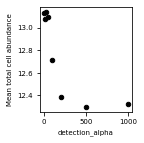

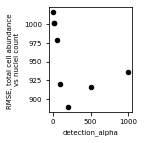

In [61]:
with matplotlib.rc_context({'figure.figsize': (2., 2.), 'font.size': 7}):
    nuclei_r_df = pd.DataFrame([np.corrcoef(df['nuclei_count'], 
                                            df['total_w_sf'])[0, 1] 
                                for df in dfs],
                               index=test_alpha_names,
                               columns=['Pearson_R'])

    nuclei_r_df['alpha'] = [sub('alphatest', '', i) for i in nuclei_r_df.index]
    nuclei_r_df['alpha'] = nuclei_r_df['alpha'].astype('float32')
    nuclei_r_df
    plt.scatter(nuclei_r_df['alpha'], nuclei_r_df['Pearson_R'], s=20, color='black');
    plt.xlabel('detection_alpha');
    plt.ylabel('Pearson R, total cell abundance \nvs nuclei count');
    plt.tight_layout()
    plt.savefig(f'{fig_path}detection_alpha_VS_PearsonR.pdf',
                bbox_inches='tight', facecolor='white')
    plt.show()

    nuclei_r_df = pd.DataFrame([df['total_w_sf'].mean() 
                                for df in dfs],
                               index=test_alpha_names,
                               columns=['mean_total_w_sf'])

    nuclei_r_df['alpha'] = [sub('alphatest', '', i) for i in nuclei_r_df.index]
    nuclei_r_df['alpha'] = nuclei_r_df['alpha'].astype('float32')
    nuclei_r_df
    plt.scatter(nuclei_r_df['alpha'], nuclei_r_df['mean_total_w_sf'], s=20, color='black');
    plt.xlabel('detection_alpha');
    plt.ylabel('Mean total cell abundance');
    plt.tight_layout()
    plt.savefig(f'{fig_path}detection_alpha_VS_mean_total_w_sf.pdf',
                bbox_inches='tight', facecolor='white')
    plt.show()

    nuclei_r_df = pd.DataFrame([np.linalg.norm(df['nuclei_count'] - df['total_w_sf']) 
                                for df in dfs],
                               index=test_alpha_names,
                               columns=['RMSE'])

    nuclei_r_df['alpha'] = [sub('alphatest', '', i) for i in nuclei_r_df.index]
    nuclei_r_df['alpha'] = nuclei_r_df['alpha'].astype('float32')
    nuclei_r_df
    plt.scatter(nuclei_r_df['alpha'], nuclei_r_df['RMSE'], s=20, color='black');
    plt.xlabel('detection_alpha');
    plt.ylabel('RMSE, total cell abundance \nvs nuclei count');
    plt.tight_layout()
    plt.savefig(f'{fig_path}detection_alpha_VS_RMSE.pdf',
                bbox_inches='tight', facecolor='white')
    plt.show()

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest'

## Compare to mapping with the regression model using R^2

In [34]:
run_regression = 'LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'
sp_data_file_regression = results_folder +run_regression+'/sp.h5ad'
adata_vis_regression = anndata.read(sp_data_file_regression)

In [35]:
np.all(adata_vis_regression.uns['mod']['obs_names'] == adata_vis.uns['mod']['obs_names'])

True

In [36]:
fig_path = scvi_run_name+'figures/'

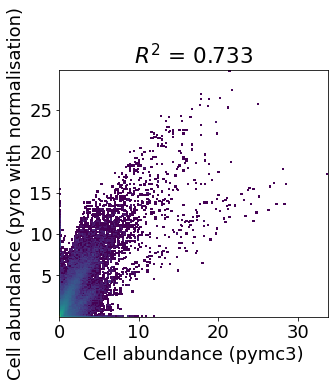

In [37]:
with matplotlib.rc_context({"figure.figsize": (5,5),
                            "axes.facecolor": "white"}):
    r = np.corrcoef(adata_vis_regression.uns['mod']['post_sample_q05']['spot_factors'].flatten(),
                    adata_vis.uns['mod']['post_sample_q05']['w_sf'].flatten())[0,1]
    
    plt.hist2d(adata_vis_regression.uns['mod']['post_sample_q05']['spot_factors'].flatten(),
                    adata_vis.uns['mod']['post_sample_q05']['w_sf'].flatten(),
               bins=200, norm=matplotlib.colors.LogNorm());
    plt.xlabel('Cell abundance (pymc3)');
    plt.ylabel('Cell abundance (pyro with normalisation)');
    plt.title(r'$R^2$ = ' + f'{np.round(r, 3)}')
    plt.tight_layout()
    #plt.savefig(f'{fig_path}pyro_vs_pymc3.pdf',
    #            bbox_inches='tight', facecolor='white')
    plt.show()

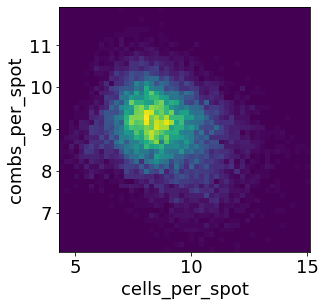

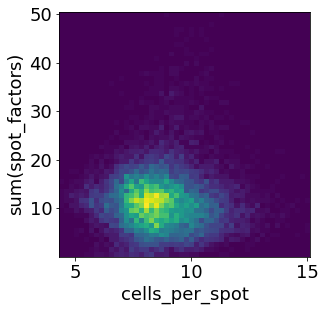

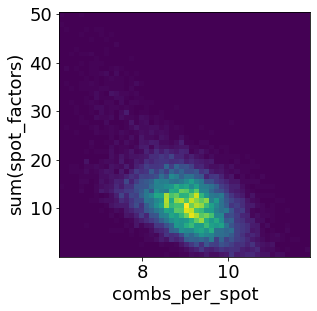

In [43]:
rcParams['figure.figsize'] = 4.5, 4.5
plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['n_s_cells_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['y_s_groups_per_location'].flatten(),
           bins=50);
plt.xlabel('cells_per_spot');
plt.ylabel('combs_per_spot');
plt.show()

plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['n_s_cells_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['w_sf'].sum(1).flatten(),
           bins=50);
plt.xlabel('cells_per_spot');
plt.ylabel('sum(spot_factors)');
plt.show()

plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['y_s_groups_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['w_sf'].sum(1).flatten(),
           bins=50);
plt.xlabel('combs_per_spot');
plt.ylabel('sum(spot_factors)');
plt.show()

Modules and their versions used for this analysis

In [44]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.